In [3]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import yaml

/Users/ayshacotterill/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/google/cloud/storage/__init__.py:35: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [4]:
# Load networks
s_no_offshore = 'test-sector-no-offshore-wind'
s_no_onshore = 'test-sector-no-onshore-wind'
s_overnight_all = 'test-sector-overnight-all'
sector_overnight_de = 'de-test-overnight/0'
sector_overnight_de_1 = 'de-test-overnight/1'
sector_overnight_de_2 = 'sector-overnight-2040-de-2'
sector_overnight = 'test-sector-overnight'
eur_test_overnight = 'eur-test-overnight/0'
scenarios = [eur_test_overnight]

n = {s: pypsa.Network(f'../results/{s}/networks/base_s_40___2030.nc') for s in scenarios} 
n_base = pypsa.Network('../resources/eur-test-overnight/0/networks/base_s_40___2030.nc')

# network1 = '../results/test-elec-no-offshore-wind/networks/base_s_5___2030.nc'
# network2 = '../results/test-elec-no-onshore-wind/networks/base_s_5___2030.nc'
# n1 = pypsa.Network(network1)
# n2 = pypsa.Network(network2)

INFO:pypsa.network.io:New version 1.0.2 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Summaries

In [5]:
with open(f"../config/plotting.default.yaml") as f:
    pypsa_config = yaml.safe_load(f)

tech_colors = pypsa_config["plotting"]["tech_colors"]
nice_names = pypsa_config["plotting"]["nice_names"]

In [6]:
sample = eur_test_overnight

In [7]:
def stacked_barh_signed(
    data,
    ax,
    *,
    tech_colors=None,
    nice_names=None,
    y_label="Total",
    group_labels=None,
    annotate_thresh=0.03,
    annotate_decimals=0,
    title=None,
    group_bracket_height=0.15,  # Height above bar for group brackets
    bar_height=0.6,
    group_label_font_size=9,
):
    """
    Plot horizontal stacked bars robust to negative values.

    Parameters:
    - data: pandas Series OR dict of Series
      - If Series: single stacked bar (original behavior)
      - If dict: single stacked bar with grouped bracket annotations above
    - ax: matplotlib axis
    - tech_colors: dict carrier -> color (fallback '#888888')
    - nice_names: dict carrier -> pretty label
    - y_label: str, text for the y-axis label
    - group_labels: dict {group_key: label}, nice labels for group annotations (for dict data)
    - annotate_thresh: fraction threshold for showing labels
    - annotate_decimals: number of decimal places for annotations (default 0)
    - title: optional plot title
    - group_bracket_height: vertical offset for group bracket annotations
    - bar_height: height of the bar
    """
    if tech_colors is None:
        tech_colors = {}
    if nice_names is None:
        nice_names = {}
    if group_labels is None:
        group_labels = {}

    # Handle both Series and dict inputs
    if isinstance(data, dict):
        # Single stacked bar with all series concatenated and group annotations
        legend_handles = {}

        # Track cumulative position and group boundaries
        left_pos = 0.0
        group_boundaries = {}  # {group_key: (start_x, end_x)}

        for group_key, series in data.items():
            series = series.dropna()
            pos = series[series > 0].sort_values(ascending=False)

            group_start = left_pos

            # Plot each carrier in this group
            for carrier, value in pos.items():
                color = tech_colors.get(carrier, "#888888")
                label = nice_names.get(carrier, carrier)

                ax.barh(
                    0, value, left=left_pos, height=bar_height, 
                    color=color, edgecolor="white"
                )

                # Annotate if above threshold
                total_pos = data[group_key][data[group_key] > 0].sum()
                if total_pos > 0 and (value / total_pos) >= annotate_thresh:
                    ax.text(
                        left_pos + value / 2,
                        0,
                        f"{value:.{annotate_decimals}f}",
                        ha="center",
                        va="center",
                        fontsize=8,
                    )

                left_pos += value

                # Add to legend (avoid duplicates)
                if label not in legend_handles:
                    legend_handles[label] = mpatches.Patch(color=color, label=label)

            group_end = left_pos
            group_boundaries[group_key] = (group_start, group_end)

        # Draw group brackets/annotations above the bar
        y_bracket = bar_height / 2 + group_bracket_height

        for group_key, (x_start, x_end) in group_boundaries.items():
            if x_end - x_start < 1e-6:  # Skip empty groups
                continue

            x_mid = (x_start + x_end) / 2

            # Get group label
            group_label = group_labels.get(group_key, group_key)

            # Draw horizontal line (bracket)
            ax.plot(
                [x_start, x_end],
                [y_bracket, y_bracket],
                color='black',
                linewidth=1.5,
                clip_on=False
            )

            # Draw vertical ticks at ends
            tick_height = 0.04
            ax.plot(
                [x_start, x_start],
                [y_bracket - tick_height, y_bracket + tick_height],
                color='black',
                linewidth=1.5,
                clip_on=False
            )
            ax.plot(
                [x_end, x_end],
                [y_bracket - tick_height, y_bracket + tick_height],
                color='black',
                linewidth=1.5,
                clip_on=False
            )

            # Add group label above bracket
            ax.text(
                x_mid,
                y_bracket + 0.08,
                group_label,
                ha="center",
                va="bottom",
                fontsize=group_label_font_size,
                fontweight="normal",
                clip_on=False
            )

        # Set axis properties
        ax.set_yticks([0])
        ax.set_yticklabels([y_label])
        ax.axvline(0, color="k", lw=0.8, alpha=0.4)

        # Set x-limits with padding
        xmax = left_pos
        pad = 0.05 * max(xmax, 1e-12)
        ax.set_xlim(-pad, xmax + pad)

        # Adjust y-limits to show brackets
        ax.set_ylim(-bar_height * 0.8, y_bracket + 0.25)

    else:
        # Single bar (original behavior)
        legend_handles = {}
        _plot_single_bar(
            data,
            ax,
            0,
            tech_colors,
            nice_names,
            annotate_thresh,
            bar_height,
            legend_handles,
            annotate_decimals,
        )
        ax.set_yticks([0])
        ax.set_yticklabels([y_label])

    if title:
        ax.set_title(title, pad=20)

    # Create legend from collected handles
    if legend_handles:
        ax.legend(
            handles=list(legend_handles.values()),
            title="Carrier",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )


def _plot_single_bar(
    s, ax, y_pos, tech_colors, nice_names, annotate_thresh, bar_height, legend_handles, annotate_decimals=0
):
    """Helper function to plot a single stacked bar at given y position."""
    s = s.dropna()
    pos = s[s > 0].sort_values(ascending=False)
    neg = s[s < 0].sort_values()

    total_pos = pos.sum()
    total_neg_abs = (-neg).sum()

    left_pos = 0.0
    left_neg = 0.0

    # Plot positives (to the right)
    for key, v in pos.items():
        color = tech_colors.get(key, "#888888")
        label = nice_names.get(key, key)
        ax.barh(
            y_pos, v, left=left_pos, height=bar_height, color=color, edgecolor="white"
        )

        if total_pos > 0 and (v / total_pos) >= annotate_thresh:
            ax.text(
                left_pos + v / 2,
                y_pos,
                f"{v:.{annotate_decimals}f}",
                ha="center",
                va="center",
                fontsize=8,
            )
        left_pos += v

        # Add to legend (avoid duplicates)
        if label not in legend_handles:
            legend_handles[label] = mpatches.Patch(color=color, label=label)

    # Plot negatives (to the left)
    for key, v in neg.items():
        color = tech_colors.get(key, "#888888")
        label = nice_names.get(key, key)
        ax.barh(
            y_pos, v, left=left_neg, height=bar_height, color=color, edgecolor="white"
        )

        if total_neg_abs > 0 and ((-v) / total_neg_abs) >= annotate_thresh:
            ax.text(
                left_neg + v / 2,
                y_pos,
                f"{v:.{annotate_decimals}f}",
                ha="center",
                va="center",
                fontsize=8,
            )
        left_neg += v

        if label not in legend_handles:
            legend_handles[label] = mpatches.Patch(color=color, label=label)

    # Draw zero reference line
    ax.axvline(0, color="k", lw=0.8, alpha=0.4, zorder=1)

    # Set x-limits with padding
    xmax = max(0.0, left_pos)
    xmin = min(0.0, left_neg)

    # Update ax limits if needed (don't shrink)
    current_xlim = ax.get_xlim()
    pad = 0.05 * max(xmax, abs(xmin), 1e-12)
    new_xlim = (min(current_xlim[0], xmin - pad), max(current_xlim[1], xmax + pad))
    ax.set_xlim(new_xlim)


def enforce_common_xlim(axes, data_list, pad_fraction=0.05):
    """
    Enforce a common x-axis limit across multiple axes when sharex=True.

    Parameters:
    - axes: array of matplotlib axes
    - data_list: list of pandas Series OR dicts of Series corresponding to each axis
    - pad_fraction: fraction of max range to add as padding (default 0.05)

    Returns:
    - tuple: (xmin, xmax) the computed common limits
    """
    # Flatten data: convert dicts to concatenated Series
    all_series = []
    for data in data_list:
        if isinstance(data, dict):
            # Concatenate all Series in the dict
            all_series.append(pd.concat(data.values()))
        else:
            # Already a Series
            all_series.append(data)
    
    # Calculate max positive and negative values across all data
    max_pos = max((s[s > 0].sum() if (s > 0).any() else 0) for s in all_series)
    max_neg = max((abs(s[s < 0].sum()) if (s < 0).any() else 0) for s in all_series)

    # Add padding
    pad = pad_fraction * max(max_pos, max_neg, 1e-12)
    xmin = -(max_neg + pad)
    xmax = max_pos + pad

    # Apply to all axes
    for a in axes:
        a.set_xlim(xmin, xmax)

    return xmin, xmax


In [ ]:
# Power of a bus should always be zero or close to zero
n[sample].buses_t["p"]

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 battery,AL0 0 biogas,AL0 0 gas,AL0 0 gas for industry,AL0 0 home battery,AL0 0 low voltage,AL0 0 rural heat,...,XK0 0 urban central heat,XK0 0 urban central water pits,XK0 0 urban central water tanks,XK0 0 urban decentral heat,XK0 0 urban decentral water tanks,co2 atmosphere,co2 sequestered,co2 stored,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,427.511251,-3.470291e-11,6.462349e-27,0.0,0.0,-1.421085e-14,-1.600142e-11,0.0,-1.111538e-10,-3.805667e-11,...,-4.728662e-11,0.0,0.0,8.647305e-11,0.0,1.409560e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-04,438.223260,-5.201173e-12,8.077936e-28,0.0,0.0,-1.421085e-14,-1.600142e-11,0.0,-4.934471e-10,4.546052e-11,...,5.593748e-12,0.0,0.0,2.071943e-11,0.0,8.503207e-10,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-07,127.396158,-2.362555e-12,1.556430e-13,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,3.727223e-10,-4.528147e-10,...,-4.252598e-11,0.0,0.0,-8.191137e-11,0.0,1.005283e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-10,276.581935,-2.558664e-11,0.000000e+00,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,1.419096e-10,-4.168896e-10,...,-2.696510e-12,0.0,0.0,-2.915215e-10,0.0,1.314319e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-13,130.568189,-1.276135e-11,-8.077936e-28,0.0,0.0,1.985789e-14,-1.600650e-11,0.0,4.024514e-11,3.135483e-10,...,-1.876082e-10,0.0,0.0,3.384457e-10,0.0,1.464457e-09,0.0,2.251454e-09,4.413823e-08,-2.010347e-08
2013-05-16,416.133884,-2.206590e-11,-3.613591e-16,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,1.274287e-10,3.346656e-10,...,2.347988e-11,0.0,0.0,1.052456e-10,0.0,1.213467e-09,0.0,2.252364e-09,4.414096e-08,-2.010347e-08
2013-05-19,575.462353,4.216361e-11,0.000000e+00,0.0,0.0,-1.421085e-14,-1.600142e-11,0.0,4.066116e-10,7.997869e-11,...,1.472955e-11,0.0,0.0,6.937739e-11,0.0,1.514451e-09,0.0,2.252364e-09,4.413914e-08,-2.010347e-08
2013-05-22,-125.403945,-2.906120e-12,0.000000e+00,0.0,0.0,-2.842171e-14,-1.600142e-11,0.0,3.961986e-10,-2.871730e-10,...,-2.579981e-11,0.0,0.0,1.827516e-10,0.0,1.253433e-09,0.0,2.252364e-09,4.413914e-08,-2.010347e-08
2013-05-25,-323.496432,-2.432188e-11,0.000000e+00,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,2.450520e-10,-1.227818e-11,...,3.125038e-10,0.0,0.0,-4.909509e-09,0.0,1.071783e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08


In [ ]:
n[sample].loads_t["p"]

Load,AL0 0,AL0 0 H2 for industry,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 agriculture machinery electric,AL0 0 gas for industry,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 low-temperature heat for industry,AL0 0 rural heat,...,XK0 0 agriculture machinery electric,XK0 0 gas for industry,XK0 0 industry electricity,XK0 0 land transport EV,XK0 0 low-temperature heat for industry,XK0 0 rural heat,XK0 0 urban central heat,XK0 0 urban decentral heat,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,430.001105,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.740489,10.273973,55.555796,...,0.985693,77.625571,97.031963,26.863982,7.990868,26.958983,9.311709,35.326403,-20674.657534,48742.009132
2013-05-04,418.793359,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,40.954101,10.273973,57.209235,...,0.985693,77.625571,97.031963,22.021291,7.990868,29.120442,10.058283,38.158727,-20674.657534,48742.009132
2013-05-07,169.706396,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.403515,10.273973,247.355921,...,0.985693,77.625571,97.031963,25.464815,7.990868,166.745284,57.594290,218.499010,-20674.657534,48742.009132
2013-05-10,195.238702,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,42.451701,10.273973,226.568426,...,0.985693,77.625571,97.031963,22.937264,7.990868,203.981669,70.455842,267.292673,-20674.657534,48742.009132
2013-05-13,-49.616839,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.101933,10.273973,413.917682,...,0.985693,77.625571,97.031963,25.672190,7.990868,682.177127,235.625900,893.908501,-20674.657534,48742.009132
2013-05-16,334.550496,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,46.704442,10.273973,132.533871,...,0.985693,77.625571,97.031963,25.108686,7.990868,66.968160,23.130991,87.753466,-20674.657534,48742.009132
2013-05-19,419.654791,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,43.237515,10.273973,58.300458,...,0.985693,77.625571,97.031963,23.346798,7.990868,27.739535,9.581313,36.349219,-20674.657534,48742.009132
2013-05-22,145.091853,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.234737,10.273973,284.134762,...,0.985693,77.625571,97.031963,26.438947,7.990868,231.956618,80.118469,303.950373,-20674.657534,48742.009132
2013-05-25,-333.281959,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,41.028535,10.273973,651.398851,...,0.985693,77.625571,97.031963,22.147284,7.990868,842.073284,290.854482,1103.432580,-20674.657534,48742.009132


p_set vs p????

In [ ]:
# why are these equal now? shouldn't some supply from generators be lost due to inefficiencies of links and lines
# need to make sure they're energy loads? i.e. not co2  

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_6651/2543941101.py:39: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



Total positive energy balance: 3233.80 TWh
Total negative energy balance: -3252.34 TWh
Total energy balance: -18.54 TWh


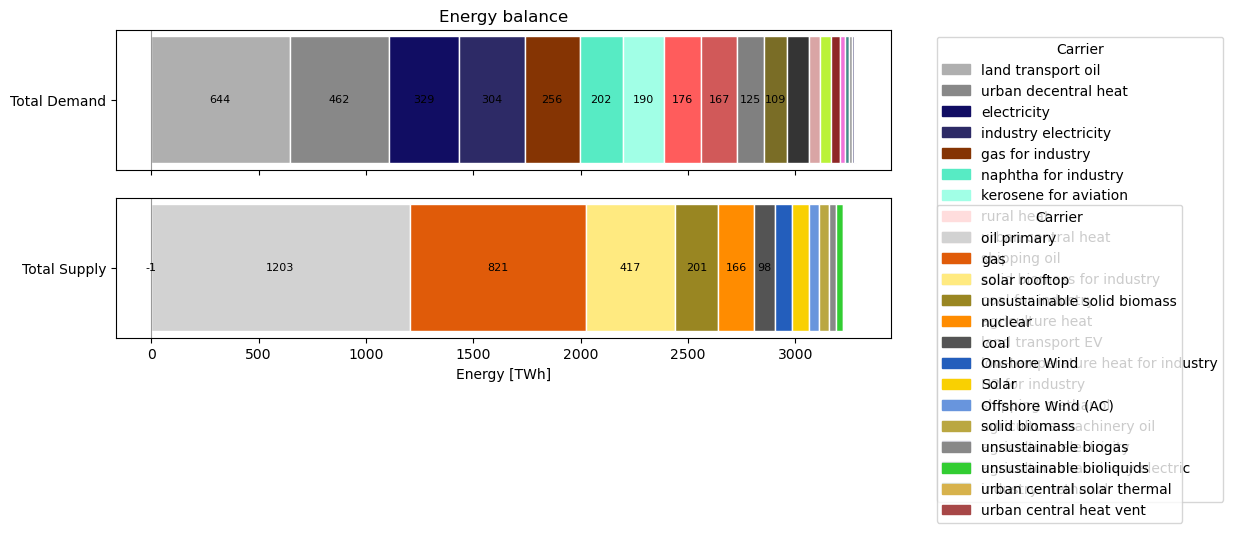

In [253]:
snapshots = pd.DatetimeIndex(n[sample].snapshots)
dt = snapshots[1] - snapshots[0]
time_delta = float(dt / pd.Timedelta(hours=1))

# calculate total demand by carrier
demand_by_carrier = n[sample].loads_t["p_set"].T.groupby(n[sample].loads["carrier"]).sum().T.sum().sort_values() * time_delta / 1e6  # TWh

demand_by_carrier_static = n[sample].loads.groupby('carrier')['p_set'].sum()
demand_by_carrier_static = demand_by_carrier_static.loc[demand_by_carrier_static>0]*time_delta*len(n[sample].snapshots)/1e6

demand_by_carrier = pd.concat([demand_by_carrier, demand_by_carrier_static])

# calculate total supply by carrier
supply_by_carrier = n[sample].generators_t["p"].T.groupby(n[sample].generators["carrier"]).sum().T.sum().sort_values() * time_delta / 1e6  # TWh

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

stacked_barh_signed(
    demand_by_carrier,
    ax[0],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Total Demand",
)

stacked_barh_signed(
    supply_by_carrier,
    ax[1],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Total Supply",
)

# Enforce common x-limit across both plots
enforce_common_xlim(ax, [demand_by_carrier, supply_by_carrier])

ax[0].set_title("Energy balance")
ax[-1].set_xlabel("Energy [TWh]")
plt.tight_layout()
plt.savefig('figures/energy_balance.png')

# print total energy balance for generators and loads
include = ["Generator", "Load"]
stats = n[sample].statistics()
energy_flows = stats[stats.index.isin(include, level=0)]
pos_energy = energy_flows.loc[energy_flows["Energy Balance"] > 0]["Energy Balance"]
neg_energy = energy_flows.loc[energy_flows["Energy Balance"] < 0]["Energy Balance"]
print(f"Total positive energy balance: {sum(pos_energy) / 1e6:.2f} TWh")
print(f"Total negative energy balance: {sum(neg_energy) / 1e6:.2f} TWh")
print(f"Total energy balance: {energy_flows['Energy Balance'].sum() / 1e6:.2f} TWh")

In [21]:
energy_balance = n[sample].statistics.energy_balance()

-0.00013971328735351562

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_71758/3072493858.py:72: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_71758/3072493858.py:72: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



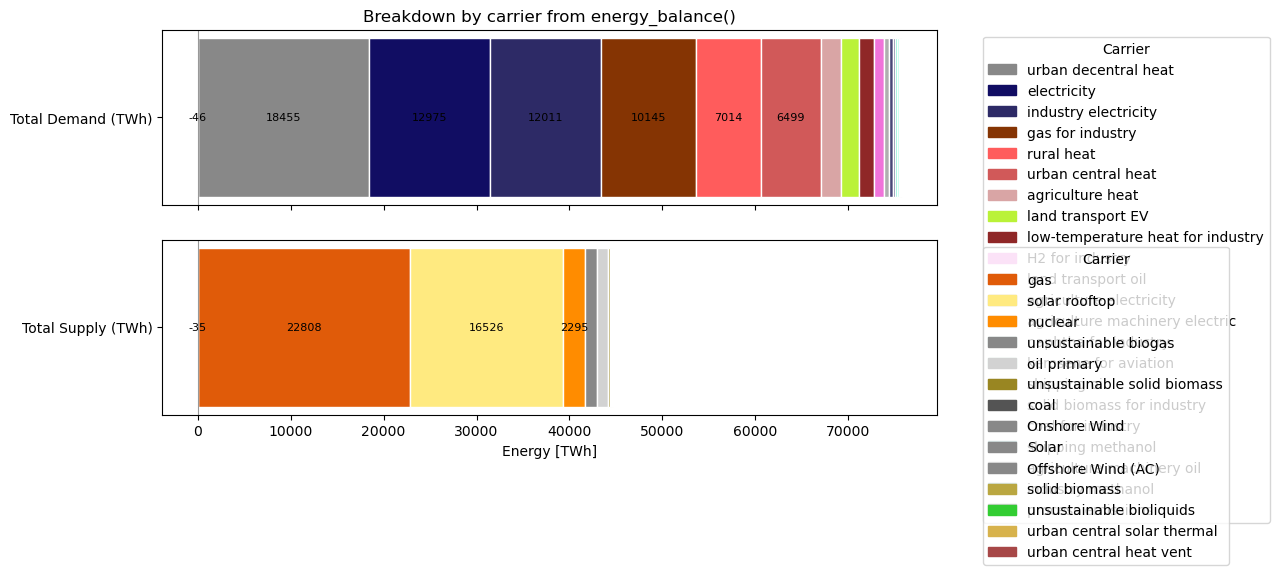

In [20]:
# Build breakdown by carrier using n[sample].statistics.energy_balance() and plot stacked bars (TWh).
# This cell tries multiple safe extraction strategies and falls back with warnings.
import warnings

eb = n[sample].statistics.energy_balance()
# Normalize to a Series containing the numeric energy values
if isinstance(eb, pd.DataFrame):
    if 'Energy Balance' in eb.columns:
        eb_series = eb['Energy Balance']
    else:
        # squeeze to series if single-column DataFrame
        eb_series = eb.squeeze()
else:
    eb_series = eb if isinstance(eb, pd.Series) else pd.Series(eb)

# Try to build a DataFrame with columns: component, name, energy
if isinstance(eb_series.index, pd.MultiIndex):
    df_eb = eb_series.rename('energy').reset_index()
    comp_col = df_eb.columns[0]
    name_col = df_eb.columns[1]
else:
    # Reset index; try to infer component by membership in network tables
    df_eb = eb_series.rename('energy').reset_index()
    df_eb.columns = ['name', 'energy']
    name_col = 'name'
    # infer component membership from generators/loads indices
    gen_idx = set(n[sample].generators.index.astype(str))
    load_idx = set(n[sample].loads.index.astype(str))
    def infer_component(x):
        xs = str(x)
        if xs in gen_idx:
            return 'Generator'
        if xs in load_idx:
            return 'Load'
        return 'Other'
    df_eb['component'] = df_eb[name_col].apply(infer_component)
    comp_col = 'component'

# Helper to compute carrier sums for a given component type and merge with component tables
def carrier_sums(component_label, table, name_col_in_df=name_col):
    subset = df_eb[df_eb[comp_col].astype(str).str.lower() == component_label.lower()]
    if subset.empty:
        warnings.warn(f'No rows found for component in energy_balance output')
        return pd.Series(dtype=float)
    # merge to get carrier information from the network table (table is a DataFrame with 'carrier')
    tab = table[['carrier']].reset_index().rename(columns={'index': name_col_in_df})
    merged = subset.merge(tab, left_on=name_col_in_df, right_on=name_col_in_df, how='left')
    if merged['carrier'].isnull().any():
        warnings.warn('Some components in energy_balance could not be matched to a carrier in the network tables')
    sums = merged.groupby('carrier')['energy'].sum().dropna()
    return sums

# Compute supply (generators) and demand (loads) sums in the same units as energy_balance
supply = carrier_sums('Generator', n[sample].generators)
demand = carrier_sums('Load', n[sample].loads)

# energy_balance values are typically in MWh (same as other prints in this notebook); convert to TWh for plotting
supply_twh = supply / 1e6 if not supply.empty else supply
demand_twh = (-demand) / 1e6 if not demand.empty else demand  # invert demand sign if negative so bars are positive

# Sort for nicer plotting
supply_twh = supply_twh.sort_values()
demand_twh = demand_twh.sort_values()

# Plot if we have data
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
stacked_barh_signed(demand_twh, ax[0], tech_colors=tech_colors, nice_names=nice_names, y_label='Total Demand (TWh)')
stacked_barh_signed(supply_twh, ax[1], tech_colors=tech_colors, nice_names=nice_names, y_label='Total Supply (TWh)')
enforce_common_xlim(ax, [demand_twh, supply_twh])
ax[0].set_title('Breakdown by carrier from energy_balance()')
ax[-1].set_xlabel('Energy [TWh]')
plt.tight_layout()
plt.show()

# Print short summary for verification
# print('Supply (TWh) by carrier:
# ', supply_twh)
# print('Demand (TWh) by carrier (positive values):
# ', demand_twh)

In [14]:
df = pd.DataFrame({
    "p_set": n[sample].loads.p_set,
    "p_optimized": n[sample].loads_t.p.iloc[0],  # if single snapshot
})
print(df.head)

<bound method NDFrame.head of                                              p_set   p_optimized
Load                                                            
AL0 0                                     0.000000    430.001105
AL0 0 H2 for industry                     0.000000      0.000000
AL0 0 agriculture electricity             9.794379      9.794379
AL0 0 agriculture heat                    9.794379      9.794379
AL0 0 agriculture machinery electric      2.098796      2.098796
...                                            ...           ...
XK0 0 rural heat                          0.000000     26.958983
XK0 0 urban central heat                  0.000000      9.311709
XK0 0 urban decentral heat                0.000000     35.326403
process emissions                    -20674.657534 -20674.657534
solid biomass for industry            48742.009132  48742.009132

[489 rows x 2 columns]>


In [35]:
n[sample].loads.loc[n[sample].loads["bus"] == "AL0 0"]

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,


In [49]:
n[sample].generators.loc[n[sample].generators["bus"] == "AL0 0"].index

Index(['AL0 0 0 offwind-float', 'AL0 0 0 offwind-ac', 'AL0 0 0 solar',
       'AL0 0 0 solar-hsat', 'AL0 0 0 onwind', 'AL0 0 0 offwind-dc'],
      dtype='object', name='Generator')

In [45]:
snapshot = "2013-05-01"

In [50]:
n[sample].generators_t["p"][n[sample].generators.loc[n[sample].generators["bus"] == "AL0 0"].index]

# n[sample].generators_t["p"].loc[snapshot][]

Generator,AL0 0 0 offwind-float,AL0 0 0 offwind-ac,AL0 0 0 solar,AL0 0 0 solar-hsat,AL0 0 0 onwind,AL0 0 0 offwind-dc
snapshot,,,,,,
2013-05-01,0.0,0.0,56.505406,0.0,-0.000000,0.0
2013-05-04,0.0,0.0,56.741452,0.0,6.902652,0.0
2013-05-07,0.0,0.0,44.977244,0.0,2.863663,0.0
2013-05-10,0.0,0.0,52.364120,0.0,-0.000000,0.0
2013-05-13,0.0,0.0,58.706524,0.0,12.975646,0.0
2013-05-16,0.0,0.0,51.856919,0.0,16.889550,0.0
2013-05-19,0.0,0.0,72.199276,0.0,8.472845,0.0
2013-05-22,0.0,0.0,34.448645,0.0,36.872286,0.0
2013-05-25,0.0,0.0,50.966015,0.0,17.066501,0.0


In [53]:
n[sample].buses_t["p"]["AL0 0"]

snapshot
2013-05-01    427.511251
2013-05-04    438.223260
2013-05-07    127.396158
2013-05-10    276.581935
2013-05-13    130.568189
2013-05-16    416.133884
2013-05-19    575.462353
2013-05-22   -125.403945
2013-05-25   -323.496432
2013-05-28    150.860240
2013-05-31   -446.565254
2013-06-03     25.611673
2013-06-06    568.465136
2013-06-09    453.477210
2013-06-12    391.675126
2013-06-15    568.370172
2013-06-18    557.259907
2013-06-21    506.598803
2013-06-24    576.366577
2013-06-27    501.922637
2013-06-30    574.314758
2013-07-03    503.023268
2013-07-06    310.646299
2013-07-09    412.877206
2013-07-12    523.402922
2013-07-15    532.115273
2013-07-18    359.362872
2013-07-21    445.853590
2013-07-24    556.307065
2013-07-27    478.511415
2013-07-30    512.015800
Name: AL0 0, dtype: float64

In [59]:
n[sample].links.columns

Index(['bus0', 'bus1', 'type', 'carrier', 'efficiency', 'active', 'build_year',
       'lifetime', 'p_nom', 'p_nom_mod', 'p_nom_extendable', 'p_nom_min',
       'p_nom_max', 'p_set', 'p_min_pu', 'p_max_pu', 'capital_cost',
       'marginal_cost', 'marginal_cost_quadratic', 'stand_by_cost', 'length',
       'terrain_factor', 'committable', 'start_up_cost', 'shut_down_cost',
       'min_up_time', 'min_down_time', 'up_time_before', 'down_time_before',
       'ramp_limit_up', 'ramp_limit_down', 'ramp_limit_start_up',
       'ramp_limit_shut_down', 'p_nom_opt', 'bus4', 'efficiency4', 'bus3',
       'efficiency3', 'bus2', 'efficiency2', 'voltage', 'underground',
       'under_construction', 'tags', 'geometry', 'dc', 'underwater_fraction',
       'project_status', 'location', 'energy to power ratio', 'reversed',
       'length_original'],
      dtype='object')

In [40]:
n[sample].links.loc[n[sample].links["bus0"] == "AL0 0"]

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,under_construction,tags,geometry,dc,underwater_fraction,project_status,location,energy to power ratio,reversed,length_original
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 H2 Electrolysis,AL0 0,AL0 0 H2,,H2 Electrolysis,0.699400,True,0,25.0,0.0,0.0,...,NaN,,,NaN,NaN,,,NaN,False,0.0
AL0 0 battery charger,AL0 0,AL0 0 battery,,battery charger,0.979796,True,0,10.0,0.0,0.0,...,NaN,,,NaN,NaN,,,NaN,False,0.0
AL0 0 urban central DAC,AL0 0,AL0 0 urban central heat,,DAC,-2.545455,True,0,20.0,0.0,0.0,...,NaN,,,NaN,NaN,,,NaN,False,0.0
AL0 0 electricity distribution grid,AL0 0,AL0 0 low voltage,,electricity distribution grid,0.970000,True,0,40.0,0.0,0.0,...,NaN,,,NaN,NaN,,,NaN,False,0.0
AL0 0 urban decentral DAC,AL0 0,AL0 0 urban decentral heat,,DAC,-2.545455,True,0,20.0,0.0,0.0,...,NaN,,,NaN,NaN,,,NaN,False,0.0


In [100]:
n[sample].links_t["p0"]

Link,AL0 0 BEV charger,AL0 0 CCGT,AL0 0 Fischer-Tropsch,AL0 0 H2 Electrolysis,AL0 0 H2 Fuel Cell,AL0 0 OCGT,AL0 0 SMR,AL0 0 SMR CC,AL0 0 Sabatier,AL0 0 V2G,...,relation/9934065-320-DC,relation/9934065-320-DC-reversed,relation/9934066-320-DC,relation/9934066-320-DC-reversed,relation/9965201-450-DC,relation/9965201-450-DC-reversed,relation/9982798-200-DC,relation/9982798-200-DC-reversed,solid biomass for industry,solid biomass for industry CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,55.267210,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,700.000000,-0.0,0.0,300.000000,48742.009132,0.0
2013-05-04,65.213114,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.0,270.215230,48742.009132,0.0
2013-05-07,32.962015,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1000.0,-0.0,2120.917963,-0.000000,-0.000000,700.0,0.0,271.072331,48742.009132,0.0
2013-05-10,47.168557,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.0,-0.000000,48742.009132,0.0
2013-05-13,72.044038,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.0,300.000000,48742.009132,0.0
2013-05-16,32.185268,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,1000.0,-0.0,2120.917963,-0.000000,-0.000000,-0.0,0.0,300.000000,48742.009132,0.0
2013-05-19,67.750240,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.0,0.0,217.085235,48742.009132,0.0
2013-05-22,54.705264,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,1000.0,-0.000000,2120.917963,-0.000000,700.0,0.0,-0.000000,48742.009132,0.0
2013-05-25,25.878704,0.0,0.0,0.0,-0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.000000,-0.000000,700.000000,-0.0,0.0,300.000000,48742.009132,0.0


In [31]:
n[sample].buses.columns

Index(['v_nom', 'type', 'x', 'y', 'carrier', 'unit', 'location',
       'v_mag_pu_set', 'v_mag_pu_min', 'v_mag_pu_max', 'control', 'generator',
       'sub_network', 'country', 'substation_lv', 'substation_off'],
      dtype='object')

In [101]:
n[sample].loads_t["p"]

Load,AL0 0,AL0 0 H2 for industry,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 agriculture machinery electric,AL0 0 gas for industry,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 low-temperature heat for industry,AL0 0 rural heat,...,XK0 0 agriculture machinery electric,XK0 0 gas for industry,XK0 0 industry electricity,XK0 0 land transport EV,XK0 0 low-temperature heat for industry,XK0 0 rural heat,XK0 0 urban central heat,XK0 0 urban decentral heat,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,430.001105,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.740489,10.273973,55.555796,...,0.985693,77.625571,97.031963,26.863982,7.990868,26.958983,9.311709,35.326403,-20674.657534,48742.009132
2013-05-04,418.793359,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,40.954101,10.273973,57.209235,...,0.985693,77.625571,97.031963,22.021291,7.990868,29.120442,10.058283,38.158727,-20674.657534,48742.009132
2013-05-07,169.706396,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.403515,10.273973,247.355921,...,0.985693,77.625571,97.031963,25.464815,7.990868,166.745284,57.594290,218.499010,-20674.657534,48742.009132
2013-05-10,195.238702,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,42.451701,10.273973,226.568426,...,0.985693,77.625571,97.031963,22.937264,7.990868,203.981669,70.455842,267.292673,-20674.657534,48742.009132
2013-05-13,-49.616839,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.101933,10.273973,413.917682,...,0.985693,77.625571,97.031963,25.672190,7.990868,682.177127,235.625900,893.908501,-20674.657534,48742.009132
2013-05-16,334.550496,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,46.704442,10.273973,132.533871,...,0.985693,77.625571,97.031963,25.108686,7.990868,66.968160,23.130991,87.753466,-20674.657534,48742.009132
2013-05-19,419.654791,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,43.237515,10.273973,58.300458,...,0.985693,77.625571,97.031963,23.346798,7.990868,27.739535,9.581313,36.349219,-20674.657534,48742.009132
2013-05-22,145.091853,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.234737,10.273973,284.134762,...,0.985693,77.625571,97.031963,26.438947,7.990868,231.956618,80.118469,303.950373,-20674.657534,48742.009132
2013-05-25,-333.281959,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,41.028535,10.273973,651.398851,...,0.985693,77.625571,97.031963,22.147284,7.990868,842.073284,290.854482,1103.432580,-20674.657534,48742.009132


In [29]:
n[sample].buses_t["p"]


Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 battery,AL0 0 biogas,AL0 0 gas,AL0 0 gas for industry,AL0 0 home battery,AL0 0 low voltage,AL0 0 rural heat,...,XK0 0 urban central heat,XK0 0 urban central water pits,XK0 0 urban central water tanks,XK0 0 urban decentral heat,XK0 0 urban decentral water tanks,co2 atmosphere,co2 sequestered,co2 stored,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,427.511251,-3.470291e-11,6.462349e-27,0.0,0.0,-1.421085e-14,-1.600142e-11,0.0,-1.111538e-10,-3.805667e-11,...,-4.728662e-11,0.0,0.0,8.647305e-11,0.0,1.409560e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-04,438.223260,-5.201173e-12,8.077936e-28,0.0,0.0,-1.421085e-14,-1.600142e-11,0.0,-4.934471e-10,4.546052e-11,...,5.593748e-12,0.0,0.0,2.071943e-11,0.0,8.503207e-10,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-07,127.396158,-2.362555e-12,1.556430e-13,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,3.727223e-10,-4.528147e-10,...,-4.252598e-11,0.0,0.0,-8.191137e-11,0.0,1.005283e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-10,276.581935,-2.558664e-11,0.000000e+00,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,1.419096e-10,-4.168896e-10,...,-2.696510e-12,0.0,0.0,-2.915215e-10,0.0,1.314319e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08
2013-05-13,130.568189,-1.276135e-11,-8.077936e-28,0.0,0.0,1.985789e-14,-1.600650e-11,0.0,4.024514e-11,3.135483e-10,...,-1.876082e-10,0.0,0.0,3.384457e-10,0.0,1.464457e-09,0.0,2.251454e-09,4.413823e-08,-2.010347e-08
2013-05-16,416.133884,-2.206590e-11,-3.613591e-16,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,1.274287e-10,3.346656e-10,...,2.347988e-11,0.0,0.0,1.052456e-10,0.0,1.213467e-09,0.0,2.252364e-09,4.414096e-08,-2.010347e-08
2013-05-19,575.462353,4.216361e-11,0.000000e+00,0.0,0.0,-1.421085e-14,-1.600142e-11,0.0,4.066116e-10,7.997869e-11,...,1.472955e-11,0.0,0.0,6.937739e-11,0.0,1.514451e-09,0.0,2.252364e-09,4.413914e-08,-2.010347e-08
2013-05-22,-125.403945,-2.906120e-12,0.000000e+00,0.0,0.0,-2.842171e-14,-1.600142e-11,0.0,3.961986e-10,-2.871730e-10,...,-2.579981e-11,0.0,0.0,1.827516e-10,0.0,1.253433e-09,0.0,2.252364e-09,4.413914e-08,-2.010347e-08
2013-05-25,-323.496432,-2.432188e-11,0.000000e+00,0.0,0.0,0.000000e+00,-1.600142e-11,0.0,2.450520e-10,-1.227818e-11,...,3.125038e-10,0.0,0.0,-4.909509e-09,0.0,1.071783e-09,0.0,2.252364e-09,4.413823e-08,-2.010347e-08


In [65]:
n[sample].loads_t.columns


AttributeError: columns

In [ ]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx


def plot_bus_power_flow(network, snapshot, bus,
                        *,
                        ts_key=None,
                        ax=None,
                        figsize=(8,8),
                        max_items=None,
                        edge_width_scale=8.0,
                        min_edge_width=0.8,
                        annotate=True,
                        cmap_in='#2ca02c',   # inflow color (green)
                        cmap_out='#d62728'   # outflow color (red)
                       ): 
    """
    Plot a simple flowchart of power flows at one bus and one snapshot.

    Contract:
    - Inputs:
      - network: a pypsa.Network-like object (or network snapshot dict entry e.g. n[sample])
      - snapshot: timestamp (str or pd.Timestamp) or index label present in the network.*_t DataFrames
      - bus: bus name/label (string) matching columns/index in network.* dataframes
    - Outputs:
      - A matplotlib Axes with a directed flow chart centered on `bus`. Returns the axes.

    Behavior / interpretation:
    - For each component type (generators, loads, stores, storage_units, links),
      the function reads the component timeseries DataFrame (typically network.generators_t['p'],
      network.loads_t['p'], ...). It handles common column conventions:
        - generators_t['p'], loads_t['p'], stores_t['p'], storage_units_t['p']
        - links_t may have columns 'p0'/'p1' or a single 'p' (tries both).
    - Direction rules:
      - generator: positive p -> generator -> bus (inflow)
      - load: positive p -> bus -> load (outflow)
      - store/storage_unit: sign determines direction; positive means power into the component columned at that bus (charging)
      - link: uses p0 or p1 depending on whether the bus is link.bus0 or link.bus1 (positive value means flow in the p0->p1 direction)
    - Edge thickness is proportional to magnitude; very small values are shown thin but non-zero.

    Edge cases handled:
    - If timeseries or columns are missing for a component the function warns and skips.
    - If snapshot is missing index, function raises a KeyError (so you can detect mismatch early).

    Returns:
    - ax: matplotlib Axes with the plot
    """

    # normalize snapshot
    try:
        if not isinstance(snapshot, (pd.Timestamp, pd.DatetimeIndex)):
            snapshot_ts = pd.Timestamp(snapshot)
        else:
            snapshot_ts = snapshot
    except Exception:
        snapshot_ts = snapshot

    # helper to try reading a timeseries table safely
    def read_ts(df_ts, comp_index):
        """
        Try to extract a Series for the requested components at the snapshot.
        df_ts: Could be a DataFrame already.
        comp_index: list-like of component names (index)
        """
        if df_ts is None:
            return pd.Series(dtype=float)
        try:
            # If we received a DataFrame
            if isinstance(df_ts, pd.DataFrame):
                # Get rows at snapshot
                s = df_ts.loc[snapshot_ts, comp_index]
                # If single component returned as scalar, convert to Series
                if np.isscalar(s):
                    return pd.Series({comp_index[0]: float(s)})
                return s.astype(float)
            else:
                return pd.Series(dtype=float)
        except KeyError as e:
            raise KeyError(f"snapshot {snapshot_ts} not found in timeseries dataframe: {e}")
        except Exception:
            try:
                s = df_ts.iloc[0].loc[comp_index]
                return s.astype(float)
            except Exception:
                return pd.Series(dtype=float)

    # Robust extractor that tries common layouts
    def extract_values_for_components(G, comp_name, comps_list, snapshot_ts, var='p'):
        """Return a dict {component: value} for comps_list by trying common layouts.

        Strategies tried:
        - MultiIndex columns where level0==var and level1==component (df[var][component])
        - Single-level columns where a column named var exists (df[var][component])
        - Single-level columns equal component names (df[component])
        - MultiIndex columns where (lvl0, component) exists
        - Last-resort per-component indexing
        """

        print("getting values for", comp_name)
        res = {}
        ts_attr = getattr(G, f"{comp_name}_t", None)

        if ts_attr is None:
            print("No attribute found")
            return res

        # If DataFrame
        if isinstance(ts_attr, pd.DataFrame):
            print("is dataframe")
            cols = ts_attr.columns
            # MultiIndex columns like ('p','gen')
            if isinstance(cols, pd.MultiIndex):
                print("multiindex")
                try:
                    if var in cols.get_level_values(0):
                        df_var = ts_attr[var]
                        for comp in comps_list:
                            try:
                                res[comp] = float(df_var.loc[snapshot_ts, comp])
                            except Exception:
                                try:
                                    res[comp] = float(df_var[comp].loc[snapshot_ts])
                                except Exception:
                                    continue
                        return res
                except Exception:
                    print("Exception")
                    pass

            # Single-level columns where var is a column
            try:
                print("Single-level columns where var is a column")
                if var in cols:
                    df_var = ts_attr[var]
                    for comp in comps_list:
                        try:
                            res[comp] = float(df_var.loc[snapshot_ts, comp])
                        except Exception:
                            try:
                                res[comp] = float(df_var[comp].loc[snapshot_ts])
                            except Exception:
                                continue
                    return res
            except Exception:
                pass

            # columns are component names directly
            try:
                for comp in comps_list:
                    if comp in ts_attr.columns:
                        try:
                            res[comp] = float(ts_attr.loc[snapshot_ts, comp])
                        except Exception:
                            try:
                                res[comp] = float(ts_attr[comp].loc[snapshot_ts])
                            except Exception:
                                continue
                if res:
                    return res
            except Exception:
                pass

            # Try searching MultiIndex second level equals component
            try:
                if isinstance(ts_attr.columns, pd.MultiIndex):
                    for comp in comps_list:
                        for lvl0 in ts_attr.columns.levels[0]:
                            try:
                                if (lvl0, comp) in ts_attr.columns:
                                    res[comp] = float(ts_attr[(lvl0, comp)].loc[snapshot_ts])
                                    break
                            except Exception:
                                continue
                    if res:
                        return res
            except Exception:
                pass

        # Last-resort: try per-component selection
        try:
            for comp in comps_list:
                try:
                    val = ts_attr.loc[snapshot_ts, comp]
                    res[comp] = float(val)
                except Exception:
                    try:
                        val = ts_attr[comp].loc[snapshot_ts]
                        res[comp] = float(val)
                    except Exception:
                        continue
        except Exception:
            pass

        return res

    # Gather components connected to the bus
    components = []

    # Helper to safely get network dataframes (exists in PyPSA)
    G = network

    # Generators
    try:
        gens_df = G.generators
        gens_here = gens_df.index[gens_df['bus'] == bus].tolist()
    except Exception:
        gens_here = []

    if len(gens_here):
        for name in gens_here:
            val = G.generators_t["p"][name]["2013-05-01"]
            components.append(('generator', name, float(val)))

    # Loads
    try:
        loads_df = G.loads
        loads_here = loads_df.index[loads_df['bus'] == bus].tolist()
        print(loads_here)
    except Exception:
        loads_here = []

    if len(loads_here):
        for name in loads_here:
            val = G.loads_t["p"][name]["2013-05-01"]
            components.append(('load', name, float(val)))

    # Stores
    try:
        stores_df = G.stores
        stores_here = stores_df.index[stores_df['bus'] == bus].tolist()
    except Exception:
        stores_here = []
    
    print("stores:", stores_here)

    if len(stores_here):
        vals = extract_values_for_components(G, 'stores', stores_here, snapshot_ts, var='p')
        if not vals:
            warnings.warn(f"Could not read stores timeseries for {len(stores_here)} stores at bus {bus}")
        for name in stores_here:
            val = vals.get(name, 0.0)
            components.append(('store', name, float(val)))

    # Storage units (storage_units)
    try:
        su_df = G.storage_units
        su_here = su_df.index[su_df['bus'] == bus].tolist()
    except Exception:
        su_here = []

    print("storage units here:", su_here)

    if len(su_here):
        vals = extract_values_for_components(G, 'storage_units', su_here, snapshot_ts, var='p')
        if not vals:
            warnings.warn(f"Could not read storage_units timeseries for {len(su_here)} storage_units at bus {bus}")
        for name in su_here:
            val = vals.get(name, 0.0)
            components.append(('storage_unit', name, float(val)))

    # Links: need special handling because they connect two buses
    try:
        links_df = G.links
    except Exception:
        links_df = pd.DataFrame()
    if not links_df.empty:
        # links_here = links_df.index[(links_df['bus0'] == bus) | (links_df['bus1'] == bus) | (links_df['bus2'] == bus) | (links_df['bus3'] == bus)].tolist()

        # boolean DataFrame: True where the cell equals the target `bus`
        matches = links_df[["bus0", "bus1", "bus2", "bus3"]].eq(bus)

        # mask of rows that contain at least one match
        mask = matches.any(axis=1)

        # list of link indices (same as your original list)
        links_here = links_df.index[mask].tolist()

        # 1) map link -> first matching bus column name (e.g. 'bus0')
        # links_buscol = matches.idxmax(axis=1)[mask].to_dict()

        # 2) map link -> bus number (int extracted from column name, e.g. 0)
        # links_busnum = {link: int(col.replace("bus", "")) for link, col in links_buscol.items()}

        # If you want every matching column per link (if a row could contain the same bus multiple times):
        links_buscols_all = matches[mask].apply(lambda row: row.index[row.values].tolist(), axis=1).to_dict()

        print(links_buscols_all)
        # print(links_busnum)

        print("links here:", links_here)
        for link in links_here:
            row = links_df.loc[link]
            bus0 = row.get('bus0')
            bus1 = row.get('bus1')
            bus2 = row.get('bus2')
            bus3 = row.get('bus3')
            buses = [bus0, bus1, bus2, bus3]
            # neighbor_buses = [bus1, bus2, bus3] if bus0 == bus else bus0

            neighbor_buses = [b for b in buses if (b != bus) and (b is not None) ] 

            if bus0 == bus: 
                used_col = "p0"
                p = G.links_t["p0"][link]["2013-05-01"]
            elif bus1 == bus: 
                used_col = "p1"
                p = G.links_t["p1"][link]["2013-05-01"]
            elif bus2 == bus: 
                used_col = "p2"
                p = G.links_t["p2"][link]["2013-05-01"]
            elif bus3 == bus: 
                used_col = "p3"
                p = G.links_t["p3"][link]["2013-05-01"]

            val = p
            print("val: ", val)


            print("link name", link)

            components.append(('link', link, float(val), neighbor_buses, used_col))


            # val = 

            # Try different variable names for link timeseries
            val = None
            used_col = None
            lt = getattr(G, 'links_t', None)
            if isinstance(lt, pd.DataFrame):
                # Try p0/p1 then 'p' then direct link column
                for candidate in ('p0', 'p1', 'p'):
                    try:
                        if isinstance(lt.columns, pd.MultiIndex) and candidate in lt.columns.get_level_values(0):
                            try:
                                v = lt[candidate].loc[snapshot_ts, link]
                                val = float(v)
                                used_col = candidate
                                break
                            except Exception:
                                pass
                        elif candidate in lt.columns:
                            try:
                                v = lt[candidate].loc[snapshot_ts, link]
                                val = float(v)
                                used_col = candidate
                                break
                            except Exception:
                                pass
                    except Exception:
                        pass
                # direct column by link name
                if val is None:
                    try:
                        if link in lt.columns:
                            v = lt.loc[snapshot_ts, link]
                            val = float(v)
                            used_col = 'auto'
                    except Exception:
                        # try multiindex search
                        try:
                            if isinstance(lt.columns, pd.MultiIndex):
                                for lvl0 in lt.columns.levels[0]:
                                    try:
                                        if (lvl0, link) in lt.columns:
                                            v = lt[(lvl0, link)].loc[snapshot_ts]
                                            val = float(v)
                                            used_col = lvl0
                                            break
                                    except Exception:
                                        continue
                        except Exception:
                            pass

            if val is None:
                warnings.warn(f"Could not read power for link {link} at snapshot {snapshot_ts}; skipping.")
                continue

            # components.append(('link', link, float(val), neighbor_bus, used_col))
            # print(components)
        print(components)

    # If nothing found, warn
    if len(components) == 0:
        warnings.warn(f"No components found for bus {bus} at snapshot {snapshot_ts}. Nothing to plot.")
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        return ax

    # Optionally reduce to top absolute flows to avoid clutter
    if max_items is not None and len(components) > max_items:
        comp_sorted = sorted(components, key=lambda c: abs(c[2]) if (len(c) > 2) else 0, reverse=True)[:max_items]
        components = comp_sorted

    # Build a small graph with central bus and peripheral nodes
    Gx = nx.DiGraph()
    center = f"bus: {bus}"
    Gx.add_node(center, kind='bus')

    for c in components:
        if c[0] == 'link':
            _, name, val, neighbor_bus, used_col = c
            node_label = f"link: {name}"
            nb_label = f"bus: {neighbor_bus}"
            # if nb_label not in Gx:
            #     Gx.add_node(nb_label, kind='bus')
            if node_label not in Gx:
                Gx.add_node(node_label, kind='link')

            # Determine direction of flow w.r.t. the central bus
            direction = None
            try:
                print("finding used columns")
                if used_col == 'p0':
                    if bus == links_df.loc[name, 'bus0']:
                        direction = 'out' if val > 0 else ('in' if val < 0 else 'none')
                    else:
                        direction = 'in' if val > 0 else ('out' if val < 0 else 'none')
                elif used_col == 'p1':
                    if bus == links_df.loc[name, 'bus1']:
                        direction = 'out' if val > 0 else ('in' if val < 0 else 'none')
                    else:
                        direction = 'in' if val > 0 else ('out' if val < 0 else 'none')
                else:
                    direction = 'in' if val > 0 else ('out' if val < 0 else 'none')
            except Exception:
                direction = 'in' if val > 0 else ('out' if val < 0 else 'none')

            if direction == 'in':
                Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
            elif direction == 'out':
                Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
            else:
                Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")

        else:
            typ, name, val = c
            node_label = f"{typ}: {name}"
            Gx.add_node(node_label, kind=typ)
            if typ in ('generator',):
                if val >= 0:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
            elif typ in ('load',):
                if val >= 0:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
            elif typ in ('store','storage_unit'):
                if val > 0:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
                elif val < 0:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
            else:
                if val >= 0:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")

    # Layout: center at (0,0), peripherals on a circle
    nodes = list(Gx.nodes())
    pos = {}
    pos[center] = (0.0, 0.0)
    periph = [n for n in nodes if n != center]
    m = len(periph)
    if m == 0:
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, f"No peripheral components for bus {bus}", ha='center')
        return ax

    radius = 1.5
    for i, node in enumerate(periph):
        angle = 2*math.pi * i / m
        pos[node] = (radius * math.cos(angle), radius * math.sin(angle))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    node_colors = []
    node_sizes = []
    for nlabel in Gx.nodes():
        kind = Gx.nodes[nlabel].get('kind', '')
        if nlabel == center:
            node_colors.append('#1f77b4')
            node_sizes.append(1000)
        elif kind == 'generator':
            node_colors.append('#98df8a')
            node_sizes.append(600)
        elif kind == 'load':
            node_colors.append('#ffbb78')
            node_sizes.append(600)
        elif kind in ('store', 'storage_unit'):
            node_colors.append('#c7c7c7')
            node_sizes.append(600)
        elif kind == 'link':
            node_colors.append('#7f7f7f')
            node_sizes.append(600)
        else:
            node_colors.append('#bbbbbb')
            node_sizes.append(600)

    nx.draw_networkx_nodes(Gx, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_labels(Gx, pos, font_size=9, ax=ax)

    weights = np.array([attr.get('weight', 0.0) for (_, _, attr) in Gx.edges(data=True)])
    max_w = float(weights.max()) if weights.size else 1.0
    if max_w == 0:
        max_w = 1.0

    for u, v, attr in Gx.edges(data=True):
        w = attr.get('weight', 0.0)
        label = attr.get('label', f"{w:.1f}")
        color = cmap_in if v == center else cmap_out
        linewidth = max(min_edge_width, (w / max_w) * edge_width_scale)
        ax.annotate("",
                    xy=pos[v], xycoords='data',
                    xytext=pos[u], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color=color, lw=linewidth, shrinkA=10, shrinkB=10),
                    )
        if annotate:
            xm = (pos[u][0] + pos[v][0]) / 2
            ym = (pos[u][1] + pos[v][1]) / 2
            ax.text(xm, ym, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.1'))

    ax.set_title(f"Power flows at bus {bus} — snapshot {snapshot}", pad=12)
    ax.set_axis_off()
    ax.set_aspect('equal')
    # plt.tight_layout()
    return ax


In [ ]:
loads_df = G.loads
loads_here = loads_df.index[loads_df['bus'] == bus].tolist()

In [110]:
loads_df = n[sample].loads
loads_here = loads_df[loads_df['bus'] == "AL0 0"]
loads_here

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,


In [111]:
n[sample].loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
AL0 0,AL0 0 low voltage,electricity,,0.0,0.0,-1.0,True
AT0 0,AT0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BA0 0,BA0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BE0 0,BE0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BG0 0,BG0 0 low voltage,electricity,,0.0,0.0,-1.0,True
...,...,...,...,...,...,...,...
SI0 0 urban decentral heat,SI0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True
SK0 0 rural heat,SK0 0 rural heat,rural heat,,0.0,0.0,-1.0,True
SK0 0 urban decentral heat,SK0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True


In [123]:
n[sample].generators_t["p"]

Generator,AL0 0 0 offwind-ac,AL0 0 0 offwind-dc,AL0 0 0 offwind-float,AL0 0 0 onwind,AL0 0 0 solar,AL0 0 0 solar rooftop,AL0 0 0 solar-hsat,AL0 0 biogas,AL0 0 biogas unsustainable,AL0 0 rural heat vent,...,XK0 0 0 solar rooftop,XK0 0 0 solar-hsat,XK0 0 biogas,XK0 0 biogas unsustainable,XK0 0 rural heat vent,XK0 0 rural solar thermal collector,XK0 0 urban central heat vent,XK0 0 urban central solar thermal collector,XK0 0 urban decentral heat vent,XK0 0 urban decentral solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,0.0,0.0,0.0,-0.000000,56.505406,1013.363106,0.0,0.0,0.0,0.0,...,661.741007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-04,0.0,0.0,0.0,6.902652,56.741452,1017.596339,0.0,0.0,0.0,0.0,...,670.416782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-07,0.0,0.0,0.0,2.863663,44.977244,806.618032,0.0,0.0,0.0,0.0,...,309.431221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-10,0.0,0.0,0.0,-0.000000,52.364120,939.093630,0.0,0.0,0.0,0.0,...,589.295423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-13,0.0,0.0,0.0,12.975646,58.706524,1052.837763,0.0,0.0,0.0,0.0,...,599.812803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-16,0.0,0.0,0.0,16.889550,51.856919,929.997533,0.0,0.0,0.0,0.0,...,576.157680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-19,0.0,0.0,0.0,8.472845,72.199276,1204.547193,0.0,0.0,0.0,0.0,...,809.682329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-22,0.0,0.0,0.0,36.872286,34.448645,617.799041,0.0,0.0,0.0,0.0,...,434.827162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-25,0.0,0.0,0.0,17.066501,50.966015,914.020142,0.0,0.0,0.0,0.0,...,513.561973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
n[sample].loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
AL0 0,AL0 0 low voltage,electricity,,0.0,0.0,-1.0,True
AT0 0,AT0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BA0 0,BA0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BE0 0,BE0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BG0 0,BG0 0 low voltage,electricity,,0.0,0.0,-1.0,True
...,...,...,...,...,...,...,...
SI0 0 urban decentral heat,SI0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True
SK0 0 rural heat,SK0 0 rural heat,rural heat,,0.0,0.0,-1.0,True
SK0 0 urban decentral heat,SK0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True


In [127]:
n[sample].buses.loc["AL0 0 low voltage"]

v_nom                     1.0
type                         
x                   19.845426
y                   41.518089
carrier           low voltage
unit                   MWh_el
location                AL0 0
v_mag_pu_set              1.0
v_mag_pu_min              0.0
v_mag_pu_max              inf
control                    PQ
generator                    
sub_network                  
country                    AL
substation_lv             NaN
substation_off            NaN
Name: AL0 0 low voltage, dtype: object

In [128]:
n[sample].generators[n[sample].generators["bus"]=="AL0 0 low voltage"]

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,location,unit
Generator,,,,,,,,,,,,,,,,,,,,,
AL0 0 0 solar rooftop,AL0 0 low voltage,PQ,,0.0,0.0,True,0.0,5281.537738,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,5281.537738,,


In [122]:
n[sample].loads_t["p"]

Load,AL0 0,AL0 0 H2 for industry,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 agriculture machinery electric,AL0 0 gas for industry,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 low-temperature heat for industry,AL0 0 rural heat,...,XK0 0 agriculture machinery electric,XK0 0 gas for industry,XK0 0 industry electricity,XK0 0 land transport EV,XK0 0 low-temperature heat for industry,XK0 0 rural heat,XK0 0 urban central heat,XK0 0 urban decentral heat,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,430.001105,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.740489,10.273973,55.555796,...,0.985693,77.625571,97.031963,26.863982,7.990868,26.958983,9.311709,35.326403,-20674.657534,48742.009132
2013-05-04,418.793359,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,40.954101,10.273973,57.209235,...,0.985693,77.625571,97.031963,22.021291,7.990868,29.120442,10.058283,38.158727,-20674.657534,48742.009132
2013-05-07,169.706396,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.403515,10.273973,247.355921,...,0.985693,77.625571,97.031963,25.464815,7.990868,166.745284,57.594290,218.499010,-20674.657534,48742.009132
2013-05-10,195.238702,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,42.451701,10.273973,226.568426,...,0.985693,77.625571,97.031963,22.937264,7.990868,203.981669,70.455842,267.292673,-20674.657534,48742.009132
2013-05-13,-49.616839,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.101933,10.273973,413.917682,...,0.985693,77.625571,97.031963,25.672190,7.990868,682.177127,235.625900,893.908501,-20674.657534,48742.009132
2013-05-16,334.550496,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,46.704442,10.273973,132.533871,...,0.985693,77.625571,97.031963,25.108686,7.990868,66.968160,23.130991,87.753466,-20674.657534,48742.009132
2013-05-19,419.654791,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,43.237515,10.273973,58.300458,...,0.985693,77.625571,97.031963,23.346798,7.990868,27.739535,9.581313,36.349219,-20674.657534,48742.009132
2013-05-22,145.091853,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.234737,10.273973,284.134762,...,0.985693,77.625571,97.031963,26.438947,7.990868,231.956618,80.118469,303.950373,-20674.657534,48742.009132
2013-05-25,-333.281959,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,41.028535,10.273973,651.398851,...,0.985693,77.625571,97.031963,22.147284,7.990868,842.073284,290.854482,1103.432580,-20674.657534,48742.009132


In [119]:
n[sample].buses.loc["AL0 0"]

v_nom                 380.0
type                       
x                 19.845426
y                 41.518089
carrier                  AC
unit                 MWh_el
location              AL0 0
v_mag_pu_set            1.0
v_mag_pu_min            0.0
v_mag_pu_max            inf
control                  PQ
generator                  
sub_network                
country                  AL
substation_lv           1.0
substation_off          1.0
Name: AL0 0, dtype: object

In [118]:
n[sample].buses.groupby("carrier").count()

,v_nom,type,x,y,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off
carrier,,,,,,,,,,,,,,,
AC,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
EV battery,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
H2,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
agriculture machinery oil,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
battery,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
biogas,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
co2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
co2 sequestered,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
co2 stored,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


getting values for generators
{}
['AL0 0', 'AL0 0 industry electricity', 'AL0 0 agriculture electricity', 'AL0 0 agriculture machinery electric']
getting values for loads


/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:217: UserWarning:

Could not read generators timeseries for 1 generators at bus AL0 0 low voltage

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:233: UserWarning:

Could not read loads timeseries for 4 loads at bus AL0 0 low voltage

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:331: UserWarning:

Could not read power for link AL0 0 BEV charger at snapshot 2013-05-01 00:00:00; skipping.

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:331: UserWarning:

Could not read power for link AL0 0 V2G at snapshot 2013-05-01 00:00:00; skipping.

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:331: UserWarning:

Could not read power for link AL0 0 urban central air heat pump at snapshot 2013-05-01 00:00:00; skipping.

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.

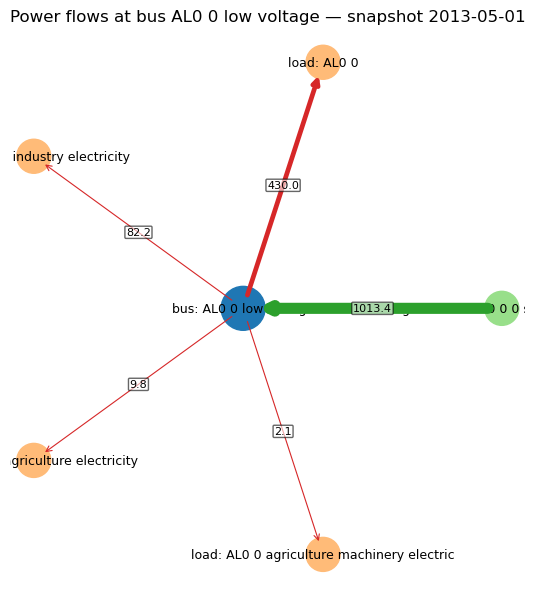

In [ ]:
# Using your variables from the notebook
sample = eur_test_overnight  # already defined above in your notebook
net = n[sample]

# Pick a snapshot in your network (match index of net.generators_t / loads_t, e.g. '2013-05-01')
snapshot = "2013-05-01"   # or net.snapshots[0] or pd.Timestamp(...)
bus = "AL0 0"             # replace with the bus you want to inspect

# Plot
ax = plot_bus_power_flow(net, snapshot, bus, figsize=(10,14))
# plt.show()
plt.savefig('figures/network_graph.png')

In [132]:
n[sample].loads_t["p"]

Load,AL0 0,AL0 0 H2 for industry,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 agriculture machinery electric,AL0 0 gas for industry,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 low-temperature heat for industry,AL0 0 rural heat,...,XK0 0 agriculture machinery electric,XK0 0 gas for industry,XK0 0 industry electricity,XK0 0 land transport EV,XK0 0 low-temperature heat for industry,XK0 0 rural heat,XK0 0 urban central heat,XK0 0 urban decentral heat,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,430.001105,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.740489,10.273973,55.555796,...,0.985693,77.625571,97.031963,26.863982,7.990868,26.958983,9.311709,35.326403,-20674.657534,48742.009132
2013-05-04,418.793359,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,40.954101,10.273973,57.209235,...,0.985693,77.625571,97.031963,22.021291,7.990868,29.120442,10.058283,38.158727,-20674.657534,48742.009132
2013-05-07,169.706396,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.403515,10.273973,247.355921,...,0.985693,77.625571,97.031963,25.464815,7.990868,166.745284,57.594290,218.499010,-20674.657534,48742.009132
2013-05-10,195.238702,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,42.451701,10.273973,226.568426,...,0.985693,77.625571,97.031963,22.937264,7.990868,203.981669,70.455842,267.292673,-20674.657534,48742.009132
2013-05-13,-49.616839,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.101933,10.273973,413.917682,...,0.985693,77.625571,97.031963,25.672190,7.990868,682.177127,235.625900,893.908501,-20674.657534,48742.009132
2013-05-16,334.550496,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,46.704442,10.273973,132.533871,...,0.985693,77.625571,97.031963,25.108686,7.990868,66.968160,23.130991,87.753466,-20674.657534,48742.009132
2013-05-19,419.654791,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,43.237515,10.273973,58.300458,...,0.985693,77.625571,97.031963,23.346798,7.990868,27.739535,9.581313,36.349219,-20674.657534,48742.009132
2013-05-22,145.091853,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.234737,10.273973,284.134762,...,0.985693,77.625571,97.031963,26.438947,7.990868,231.956618,80.118469,303.950373,-20674.657534,48742.009132
2013-05-25,-333.281959,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,41.028535,10.273973,651.398851,...,0.985693,77.625571,97.031963,22.147284,7.990868,842.073284,290.854482,1103.432580,-20674.657534,48742.009132


In [ ]:
n[sample].generators_t["p"]["2013-"]

Generator,AL0 0 0 offwind-ac,AL0 0 0 offwind-dc,AL0 0 0 offwind-float,AL0 0 0 onwind,AL0 0 0 solar,AL0 0 0 solar rooftop,AL0 0 0 solar-hsat,AL0 0 biogas,AL0 0 biogas unsustainable,AL0 0 rural heat vent,...,XK0 0 0 solar rooftop,XK0 0 0 solar-hsat,XK0 0 biogas,XK0 0 biogas unsustainable,XK0 0 rural heat vent,XK0 0 rural solar thermal collector,XK0 0 urban central heat vent,XK0 0 urban central solar thermal collector,XK0 0 urban decentral heat vent,XK0 0 urban decentral solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,0.0,0.0,0.0,-0.000000,56.505406,1013.363106,0.0,0.0,0.0,0.0,...,661.741007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-04,0.0,0.0,0.0,6.902652,56.741452,1017.596339,0.0,0.0,0.0,0.0,...,670.416782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-07,0.0,0.0,0.0,2.863663,44.977244,806.618032,0.0,0.0,0.0,0.0,...,309.431221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-10,0.0,0.0,0.0,-0.000000,52.364120,939.093630,0.0,0.0,0.0,0.0,...,589.295423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-13,0.0,0.0,0.0,12.975646,58.706524,1052.837763,0.0,0.0,0.0,0.0,...,599.812803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-16,0.0,0.0,0.0,16.889550,51.856919,929.997533,0.0,0.0,0.0,0.0,...,576.157680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-19,0.0,0.0,0.0,8.472845,72.199276,1204.547193,0.0,0.0,0.0,0.0,...,809.682329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-22,0.0,0.0,0.0,36.872286,34.448645,617.799041,0.0,0.0,0.0,0.0,...,434.827162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-25,0.0,0.0,0.0,17.066501,50.966015,914.020142,0.0,0.0,0.0,0.0,...,513.561973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
